#  Baseline CNN Model for MNIST

In [1]:
from numpy import mean
from numpy import std
from matplotlib import pyplot as plt
from sklearn.model_selection import KFold
from tensorflow.keras.datasets import mnist
from tensorflow.keras.utils import to_categorical
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D , MaxPooling2D , Dense , Flatten 
from tensorflow.keras.optimizers import SGD

In [2]:
def load_dataset() :
    # Load train and test dataset
    (trainX , trainY) , (testX , testY) = mnist.load_data()

    # reshape dataset to have a single channel
    trainX = trainX.reshape((trainX.shape[0], 28 , 28 , 1 )) # 1 is for one channel ( grayscale )
    # train_x[0] represents the no. of training examples 
    # train_x[1] represnets the te height and width of each image (x,y)
    testX = testX.reshape((testX.shape[0], 28, 28 , 1 ))

    # One hot encoding
    from keras.utils import to_categorical
    # one hot encoder for the target values 
    # We also know that there are 10 classes and that classes are represented as unique integers.
    # We can, therefore, use a one hot encoding for the class element of each sample, transforming the integer into a 10 element 
    # binary vector with a 1 for the index of the class value, and 0 values for all other classes. We can achieve this with the 
    # to_categorical() utility function.
    trainY = to_categorical(trainY)
    testY = to_categorical(testY)
    
    return trainX , trainY , testX , testY 

# Normalization : 

In [3]:
# Scale pixels
def prep_pixels(train, test):
    # convert from integers to floats
    train_norm = train.astype('float32')
    test_norm = test.astype('float32')
    
    # normalize to range 0-1
    train_norm = train_norm / 255.0
    test_norm = test_norm / 255.0
    
    # return normalized images
    return train_norm, test_norm

# Define CNN Model
All layers will use the ReLU activation function and the He weight initialization scheme, both best practices.
Relu Activation Function ensure that the non-linearity concept is applied as data moves through layers

In [4]:
def define_model():
    model = Sequential()
    
    # 32 filters and a single convolutional layer with a small filter size (3,3) ,
    model.add(Conv2D(32, (3, 3), activation='relu', kernel_initializer='he_uniform', input_shape=(28, 28, 1)))
    model.add(MaxPooling2D((2, 2)))
    model.add(Flatten()) 
    
    # Dense layer of 100 nodes is added between the feature extractor and the output layer to interpret features
    model.add(Dense(100, activation='relu', kernel_initializer='he_uniform'))
     
    # Softmax converts a vector of values to a probability distribution.
    model.add(Dense(10, activation='softmax')) # 10 classes
    
    # Compile model
    opt = SGD(learning_rate=0.01, momentum=0.9)
    model.compile(optimizer=opt, loss='categorical_crossentropy', metrics=['accuracy'])
    return model

# Evaluate Model using K-Fold Cross Validation :

In [5]:
def evaluate_model( dataX, dataY, n_folds=5 ): # k=5 to avoid long running time 
    scores, histories = list(), list()
    
    # Prepare cross validation
    kfold = KFold(n_folds, shuffle=True, random_state=1)
    
    # Enumerate splits
    for train_ix, test_ix in kfold.split(dataX): # Each test set will be 20% of the training dataset, or about 12,000 examples
        
        # Define model
        model = define_model()
        
        # Select rows for train and test
        trainX, trainY, testX, testY = dataX[train_ix], dataY[train_ix], dataX[test_ix], dataY[test_ix]
        
        # Fit model
        history = model.fit(trainX, trainY, epochs=10, batch_size=32, validation_data=(testX, testY), verbose=0)
        
        # Save model
        model.save('final_model.h5')
        
        # Evaluate model on Test Dataset 
        _, acc = model.evaluate(testX, testY, verbose=0)
        print('> %.3f' % (acc * 100.0))
        
        # Store scores
        scores.append(acc)
        histories.append(history)
    return scores, histories

# The evaluate_model() function below implements these behaviors, taking the training dataset as arguments and returning 
# a list of accuracy scores and training histories that can be later summarized.

# Plot Diagnostic Learning Curves

In [6]:
def summarize_diagnostics(histories):
    for i in range(len(histories)):
        
        # Plot Loss
        plt.subplot(2, 1, 1) # ( no. of rows , no. of columns , index )
        plt.title('Cross Entropy Loss' , fontsize = 16 )
        plt.plot(histories[i].history['loss'], color='blue', label='train' , linewidth = 3.0 )
        plt.plot(histories[i].history['val_loss'], color='orange', label='test' , linewidth = 3.0 )
        plt.legend( ['Training loss' , 'Validation Loss' ] , fontsize = 18 )
        plt.xlabel('Epochs ', fontsize = 16 )
        plt.ylabel('Loss', fontsize = 16 )  
        
        # Plot Accuracy
        plt.subplot(2, 1, 2)
        plt.title('Classification Accuracy' , fontsize = 16 )
        plt.plot(histories[i].history['accuracy'], color='blue', label='train' , linewidth = 3.0 )
        plt.plot(histories[i].history['val_accuracy'], color='orange', label='test' , linewidth = 3.0 )
        plt.legend( ['Training Accuracy', 'Validation Accuracy'] , fontsize=18 )
        plt.xlabel('Epochs ', fontsize = 16 )
        plt.ylabel('Accuracy', fontsize = 16 )
        plt.show()

# Summarize Model Performance 
Next, the classification accuracy scores collected during each fold can be summarized by calculating the mean and standard deviation. This provides an estimate of the average expected performance of the model trained on this dataset, with an estimate of the average variance in the mean. We will also summarize the distribution of scores by creating and showing a box and whisker plot.

In [7]:
def summarize_performance(scores):
    
    # Print Summary
    print('Accuracy: mean=%.3f std=%.3f, n=%d' % (mean(scores)*100, std(scores)*100, len(scores)))
    # Box and Whisker plots of results
    plt.boxplot(scores)
    plt.show()


# Testing Model

Next, a diagnostic plot is shown, giving insight into the learning behavior of the model across each fold.

In this case, we can see that the model generally achieves a good fit, with train and test learning curves converging. There is no obvious sign of overfitting or underfitting.

> 98.425
> 98.733
> 98.533
> 98.908
> 98.708


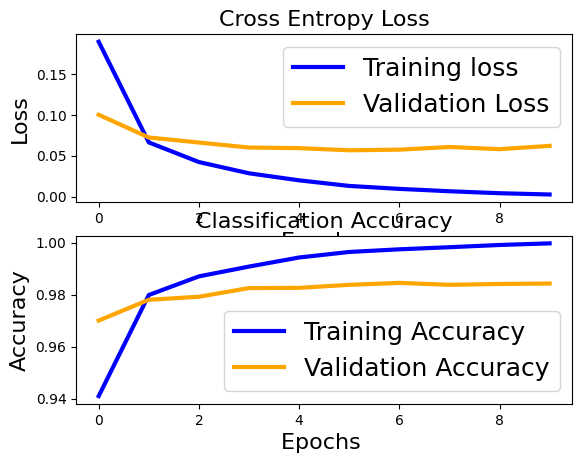

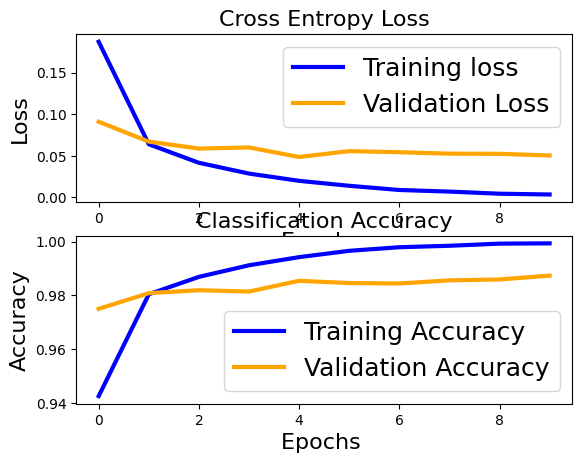

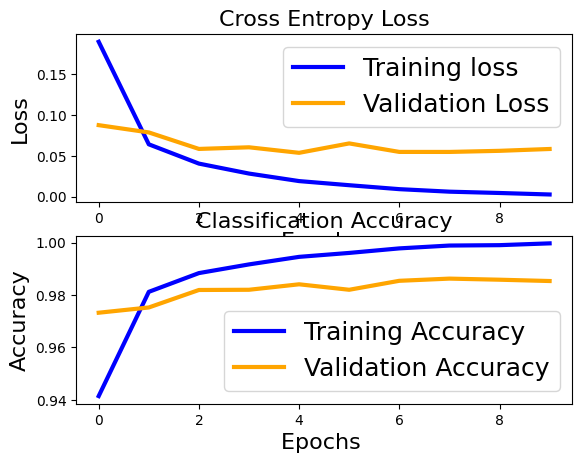

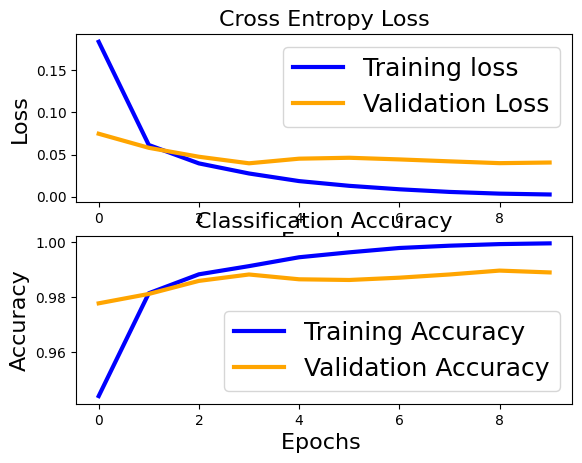

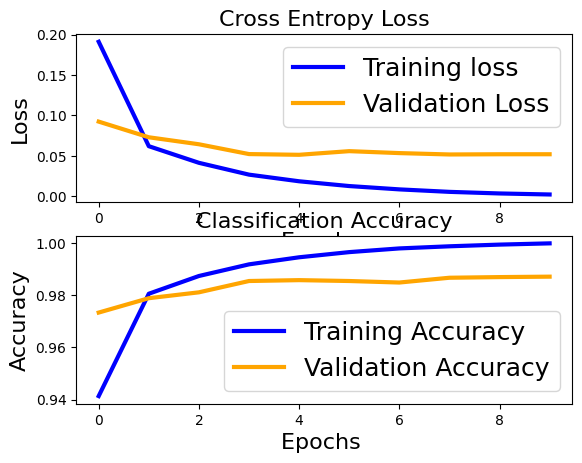

Accuracy: mean=98.662 std=0.168, n=5


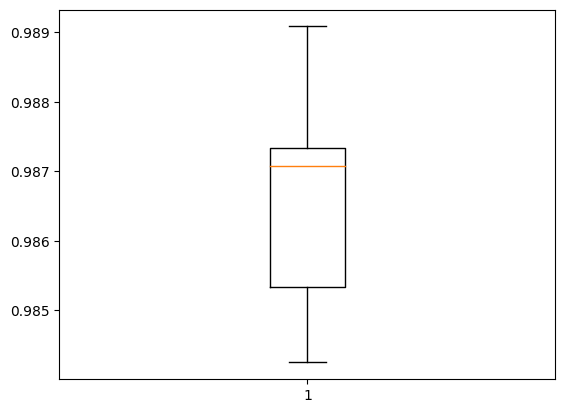

In [8]:
# Run the test_model for evaluating a model
def run_test_model():
    
    # Load dataset
    trainX, trainY, testX, testY = load_dataset()
    
    # Prepare pixel data
    trainX, testX = prep_pixels(trainX, testX)
    
    # Evaluate model
    scores, histories = evaluate_model(trainX, trainY)
    
    # Learning curves
    summarize_diagnostics(histories)
    
    # Summarize estimated performance
    summarize_performance(scores)

# entry point, run 
run_test_model()

# Make a Prediction on a New Image

In [9]:
from numpy import argmax
from keras_preprocessing.image import load_img
from keras_preprocessing.image import img_to_array
from keras.models import load_model

In [10]:
# Load and Prepare the sample image
filename = r"E:\Level Three Second Term\Selected-2\PROJECT\sample_image.png"
def load_image(filename):
    # Load the image
    img = load_img(filename, grayscale=True, target_size=(28, 28))
    
    # Convert to array
    img = img_to_array(img)
    
    # Reshape into a single sample with 1 channel
    img = img.reshape(1, 28, 28, 1)
    
    # Prepare pixel data
    img = img.astype('float32')
    img = img / 255.0
    return img

In [13]:
# Load an image and Predict the Class
def run_example():
    # Load the image
    img = load_image(filename)
    
    # Load model
    model = load_model('final_model.h5')
    
    # Predict the Class
    predict_value = model.predict(img)
    digit = argmax(predict_value) 
    print(digit)

# Entry point, Run the example
run_example()

1/1 [==============================] - 0s 104ms/step
7
